In [4]:
## IMPORTANT !

# In the first order need to set the number of CPU 
# for calculation before launching (depends on computer's number of cores)
n_jobs= 50

#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

#from mne.viz import plot_connectivity_circle
#from mne_connectivity.viz import plot_connectivity_circle

##### Load path var

In [5]:
path = '/media/hcs-psy-narun/Alina/HCP_results/aug_rerun_v5/hcp_aging/results/totalIQ/'

In [6]:
path_obs = '/media/data/HCPAging/data/New_MLTabs_OneTrain_latest_short/totalIQ/'

In [7]:
path_img_out = '/media/hcs-psy-narun/Alina/HCP_results/predicted_values_for_datasets_5/'

##### Load data

In [8]:
#load observed data
targ_obs = pd.DataFrame()
for fold in sorted(os.listdir(path_obs)):
    series = pd.read_csv(glob.glob(path_obs+fold+'/*_test*')[0], index_col=0)
    series.columns = ['y_obs']
    series['fold'] = np.full(len(series), fold)
    targ_obs = pd.concat([targ_obs,series], axis=0)
    

In [9]:
#load predicted data
pred = pd.DataFrame()
ll = {}
for fold in sorted(os.listdir(path_obs)):
    ll[fold] = {}
    for file in sorted(glob.glob(path+'layer1/*/*/'+fold+'/test_results.csv')):
        ll[fold][file.split('/')[-4]+'_'+file.split('/')[-3]] = pd.read_csv(file, index_col=0, squeeze=True)
    for file in sorted(glob.glob(path+'layer2/*/*/*/'+fold+'/test_results.csv')):
        ll[fold][file.split('/')[-5]+'_'+file.split('/')[-4]+'_'+file.split('/')[-3]] = pd.read_csv(file, index_col=0, squeeze=True)
    ll[fold] = pd.DataFrame(ll[fold])
    
    pred = pd.concat([pred, ll[fold]], axis=0, ignore_index=True)

    

In [10]:
#combine them into one array (stick folds together)

df_y_all =pd.concat([pred, pd.DataFrame(targ_obs.values, columns=['y_obs', 'fold'])], axis=1)
df_y_all.index = targ_obs.index


##### Assign labels

In [11]:
A_s = ['Total Brain Volume',
       'CARIT Contrast', #1    
       'CARIT FC',    
       'Cortical Thickness',    
       'Facename: Encoding-Recall',#4
       'Facename: Encoding-Distractor',#5
       'Facename: Recall-Distractor',#6    
       'Facename FC',
       'Resting State FC',
       'Subcortical Volume', 
       'Cortical Surface', 
       'Vismotor Contrast',
       'Vismotor FC']
         
A_st = ['Stacked: All', #set1
        'Stacked: Task Contrast', #set2
        'Stacked: Non Task', #set3
        'Stacked: Task FC', #set4
        'Stacked: Task Contrast & Task FC', #set5
        'Stacked: All excluding Task FC', #set6  with Task GLM
        'Stacked: All excluding Task Contrast',  #set7 with Task FC
        'Stacked: Resting and Task FC'] #set8

lbl_A = []
algs = ['eNet', 'RF', 'SVR', 'XGB']

for single, stack, labels in zip([A_s],[A_st], [lbl_A]):
        
    for i in algs:
        for lbl in single:
            labels+= [lbl+', '+i]

    for i in algs:    
        for j in algs:
            for lbl in stack:
                labels+= [lbl+', '+i+'+'+j]
lbl_A.append('y_obs')
lbl_A.append('fold')

In [12]:
df_y_all.columns = lbl_A 

##### Run Bootstsrap

In [13]:
#bootstrapping
i=0
#empty dict for storing indexes after each trial
dt_boot={}
while i<5000: #number of trials (shuffles)
    #shuffle
    boot = resample(df_y_all, replace=True, n_samples=len(df_y_all.index), random_state=i)
    #calculate indexes for this trial
    cor, r2, mse, mae, cols = [], [], [], [], []
    for col in boot.columns[0:-2]:
        corr, _ = pearsonr(boot['y_obs'], boot[col])
        cor += [corr]
        r2 += [r2_score(boot['y_obs'], boot[col])]
        mse += [mean_squared_error(boot['y_obs'], boot[col])]
        mae += [mean_absolute_error(boot['y_obs'], boot[col])]
        cols +=[col]
    #write it to dict
    dt_boot[i] = pd.DataFrame({'r2':r2, 'mse':mse, 'mae':mae, 'cor':cor}, index = cols)
    i+=1

#transform dict to mo convenient tables sorted by type of index
#empty dict
dbt_r2 = {}
dbt_mse = {}
dbt_mae = {}
dbt_cor = {}
#aassign each index to own dict
for key in dt_boot.keys():
    dbt_r2[key] = dt_boot[key].iloc[:,0]
    dbt_mse[key] = dt_boot[key].iloc[:,1]
    dbt_mae[key] = dt_boot[key].iloc[:,2]
    dbt_cor[key] = dt_boot[key].iloc[:,3]
#transform to tables
bt_r2 = pd.DataFrame(dbt_r2).T
bt_mse = pd.DataFrame(dbt_mse).T
bt_mae = pd.DataFrame(dbt_mae).T
bt_cor = pd.DataFrame(dbt_cor).T
#save tables
#bt_r2.to_csv(path2+'r2_bootstrap.csv')
#bt_mse.to_csv(path2+'mse_bootstrap.csv')
#bt_mae.to_csv(path2+'mae_bootstrap.csv')
#bt_cor.to_csv(path2+'cor_bootstrap.csv')

#create table with mean performance
bt_mean = pd.DataFrame({'r2': np.array(bt_r2.mean()),
                        'mse': np.array(bt_mse.mean()),
                        'mae': np.array(bt_mae.mean()),
                        'cor': np.array(bt_cor.mean()),
                             }, index = bt_r2.columns)
#bt_mean.index = lblY
#save mean table
#bt_mean.to_csv(path2+'mean_boot_perf.csv')

#display
print('Mean Performance based on Bootstrapping of Predicted and Observed Values across Test Folds')
display(bt_mean.sort_values(by='cor', ascending=False))

Mean Performance based on Bootstrapping of Predicted and Observed Values across Test Folds


,r2,mse,mae,cor
"Stacked: All, eNet+RF",0.371923,0.636309,0.637409,0.613881
"Stacked: All, eNet+eNet",0.370054,0.638179,0.637696,0.611353
"Stacked: All, eNet+SVR",0.368491,0.639695,0.640882,0.609343
"Stacked: All excluding Task FC, eNet+eNet",0.357602,0.650723,0.644519,0.599509
"Stacked: All excluding Task FC, eNet+SVR",0.356864,0.651410,0.646709,0.598965
...,...,...,...,...
"Total Brain Volume, SVR",0.021993,0.991727,0.790824,0.172527
"CARIT Contrast, SVR",-0.007702,1.021841,0.813831,0.068853
"CARIT Contrast, eNet",0.000699,1.013317,0.814135,0.067270
"CARIT Contrast, XGB",-0.034491,1.048908,0.820825,0.029383


##### Select the best modality for single modality and stack separatelly
##### Based on R2

In [14]:
enet = (bt_mean.loc[[i for i in bt_mean.index if ', eNet' in i and 'RF' not in i and 'SVR' not in i and 'XGB' not in i]]).sort_values(by='cor', ascending=False)

enet_best_single = enet.loc[[i for i in enet.index if 'Stacked' not in i]].index[0]
enet_best_stack = enet.loc[[i for i in enet.index if 'Stacked' in i]].index[0]

In [15]:
print('Best modalities in single and stack:')
print(' ')
print(enet_best_single)
print(enet_best_stack)

Best modalities in single and stack:
 
Facename: Encoding-Distractor, eNet
Stacked: All, eNet+eNet


##### Plot

##### Across stacked modalities

In [16]:
#calculate the difference
df = bt_cor[[i for i in bt_cor.columns if 'Stacked' in i]]
diff = {}

for col in df.columns:
    diff[col] = df[enet_best_stack] - df[col]
    
diff = pd.DataFrame(diff).reindex(columns=df.mean().sort_values(ascending=False).index) #.drop(enet_best_stack)
del diff[enet_best_stack]

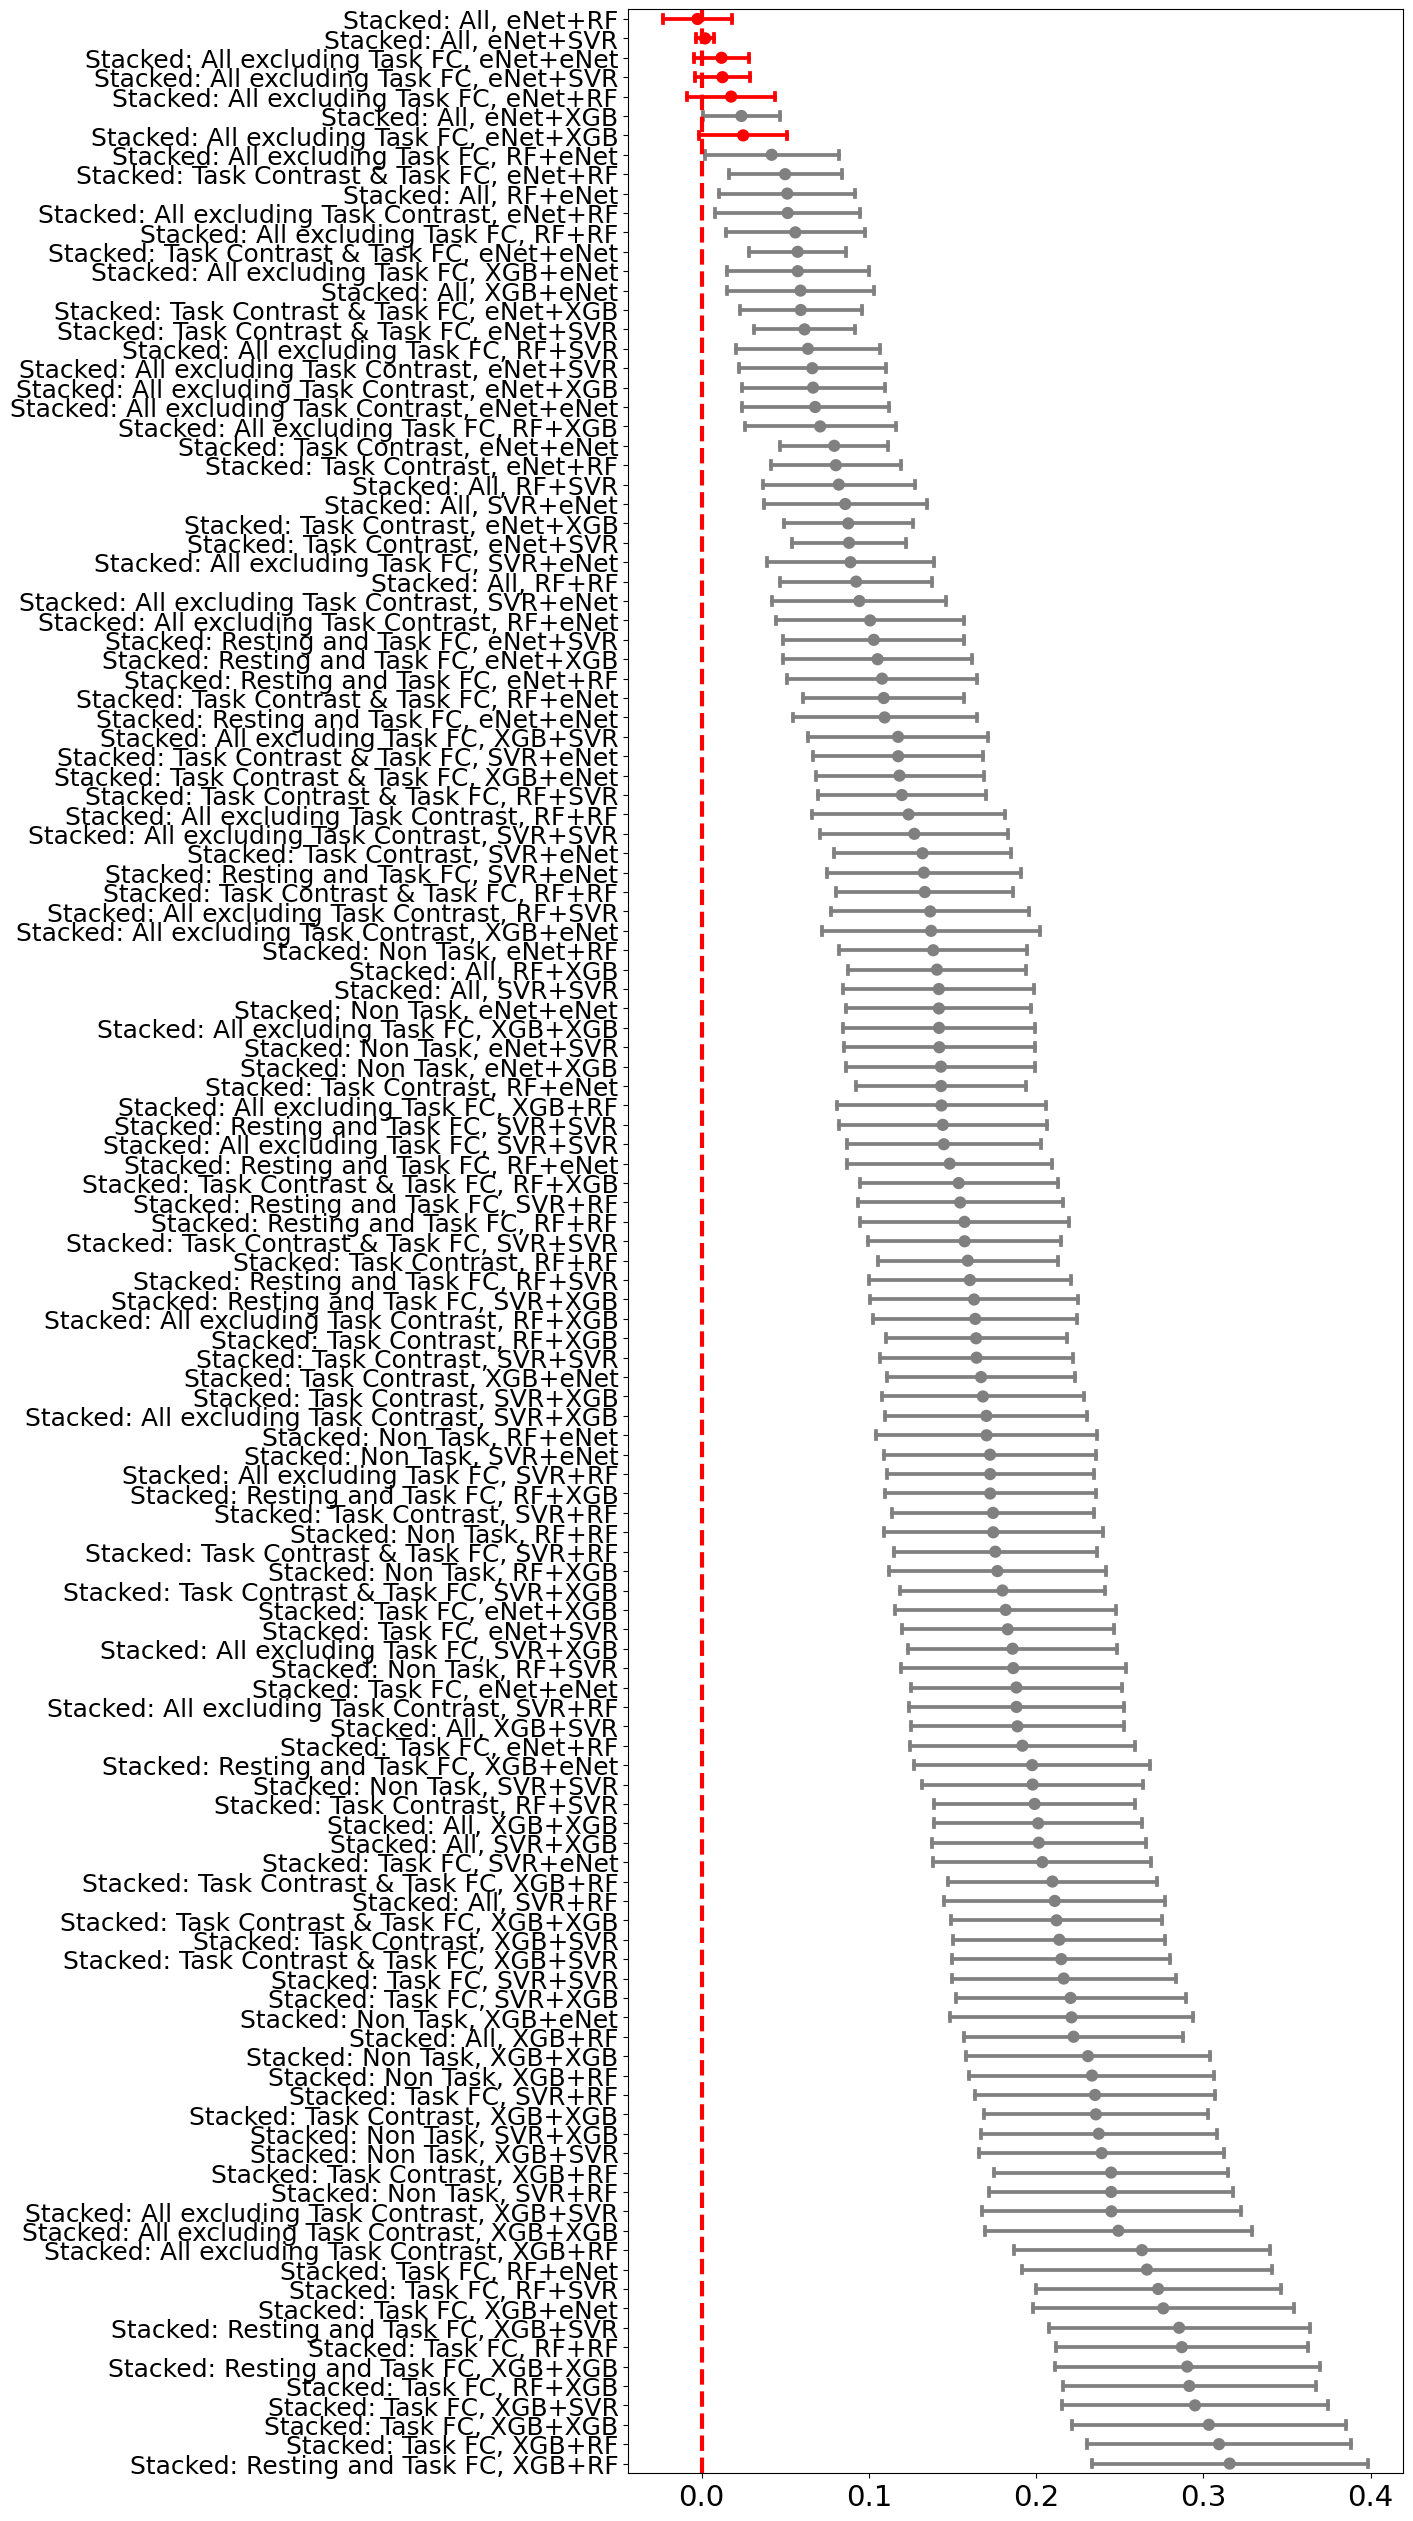

In [17]:
#plot
my_pal = []

for col in diff.columns:
    
    ci1 = st.t.interval(0.95, df=len(diff.index)-1, loc=np.mean(diff[col]), scale=np.std(diff[col]))[0]
    
    if ci1 <=0:
        my_pal += ['red']
    else:
        my_pal += ['gray']

fig = plt.figure(figsize=(10,32))
def my_func(vec):
    ci = st.t.interval(0.95, df=len(vec)-1, loc=np.mean(vec), scale=np.std(vec))
    return ci
sns.pointplot(data = diff, orient='h',  errorbar=my_func, capsize=.4, join=False, palette=my_pal)
plt.axvline(0, color='r', linestyle='dashed', linewidth=3)
plt.xticks(fontsize=21)
plt.yticks(fontsize=18)

plt.savefig(path_img_out+'hcpa_btstrpd_stacked_plot_image_COR.svg',bbox_inches='tight')

plt.show()

##### Across single modalities

In [18]:
#calculate the difference
df2 = bt_cor[[i for i in bt_cor.columns if 'Stacked' not in i]]
diff2 = {}

for col in df2.columns:
    diff2[col] = df2[enet_best_single] - df2[col]
    
diff2 = pd.DataFrame(diff2).reindex(columns=df2.mean().sort_values(ascending=False).index)#.drop(enet_best_single)) 
del diff2[enet_best_single]

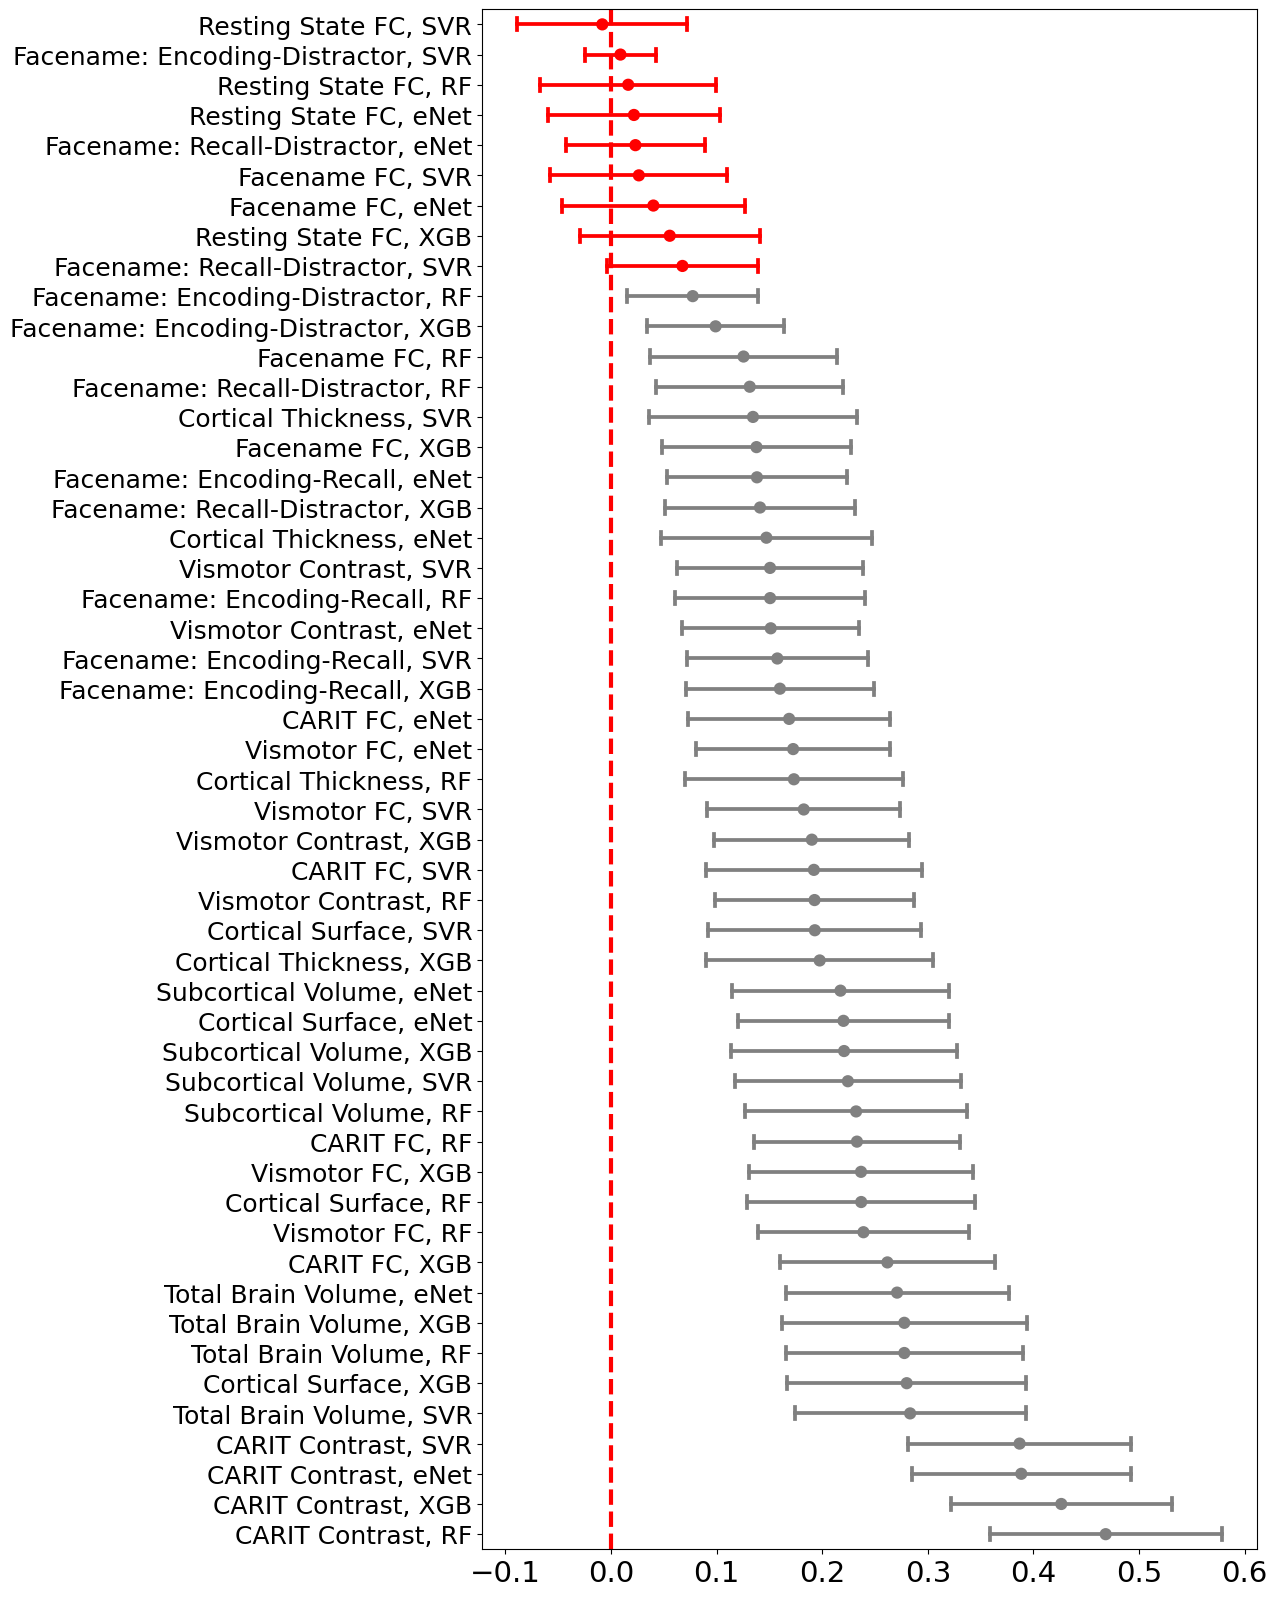

In [19]:
#plot
my_pal2 = []

for col in diff2.columns:
    
    ci1 = st.t.interval(0.95, df=len(diff2.index)-1, loc=np.mean(diff2[col]), scale=np.std(diff2[col]))[0]
    
    if ci1 <=0:
        my_pal2 += ['red']
    else:
        my_pal2 += ['gray']

fig = plt.figure(figsize=(10,20))
def my_func(vec):
    ci = st.t.interval(0.95, df=len(vec)-1, loc=np.mean(vec), scale=np.std(vec))
    return ci
sns.pointplot(data = diff2, orient='h',  errorbar=my_func, capsize=.4, join=False, palette=my_pal2)
plt.axvline(0, color='r', linestyle='dashed', linewidth=3)
plt.xticks(fontsize=21)
plt.yticks(fontsize=18)

plt.savefig(path_img_out+'hcpa_btstrpd_single_plot_image_COR.svg',bbox_inches='tight')

plt.show()